<a href="https://colab.research.google.com/github/ps2181/Monte-Carlo-simulation-of-stocks/blob/main/Monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Adj Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

print(returns)


[*********************100%%**********************]  6 of 6 completed

Ticker        BHP.AX    CBA.AX    NAB.AX    STO.AX    TLS.AX    WBC.AX  \
Date                                                                     
2022-04-20 -0.016363  0.002149  0.000601 -0.010817  0.000000 -0.001639   
2022-04-21 -0.030593  0.010351  0.009919  0.017011  0.002481  0.006158   
2022-04-22 -0.043590 -0.027503 -0.013690 -0.026284  0.002475 -0.012240   
2022-04-26 -0.058363 -0.005884 -0.012070 -0.042945 -0.012346 -0.012805   
2022-04-27  0.007665 -0.016706 -0.016494  0.010256 -0.005000 -0.018828   
...              ...       ...       ...       ...       ...       ...   
2024-06-17 -0.012764  0.001436  0.006853 -0.016064  0.014286  0.006719   
2024-06-18  0.006112  0.019842  0.020987  0.000000  0.014084  0.009270   
2024-06-19 -0.001402 -0.008126  0.004722  0.010884  0.000000 -0.003674   
2024-06-20  0.000234  0.006381  0.000553  0.004038  0.002778  0.004793   
2024-06-21  0.000702 -0.000548  0.000553  0.021448  0.013850 -0.000367   

Ticker      portfolio  
Date         

In [8]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       195.45
Value at Risk 95th CI    :       1583.53
Conditional VaR 95th CI  :       2294.05


In [9]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       1355.07
Normal CVaR 95th CI      :       1748.96
t-dist VaR 95th CI       :       1300.15
t-dist CVaR 95th CI      :       1837.06


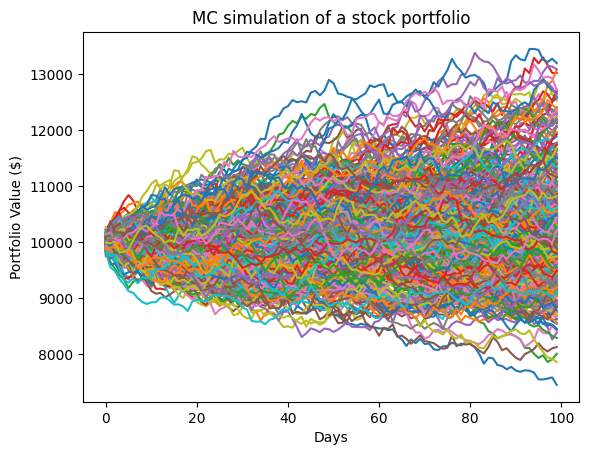

In [10]:
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [11]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $1172.1
CVaR $1565.24


In [12]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       1583.53
 Normal VaR 95th CI       :       1355.07
 t-dist VaR 95th CI       :       1300.15
 MC VaR  95th CI          :       1172.1

CVaR:
 historical CVaR 95th CI  :       2294.05
 Normal CVaR 95th CI      :       1748.96
 t-dist CVaR 95th CI      :       1837.06
 MC CVaR 95th CI          :       1565.24
